In [1]:
import numpy as np; print("numpy:", np.__version__)
import pandas as pd; print("pandas:", pd.__version__)
import sklearn; print("sklearn:", sklearn.__version__)

numpy: 2.0.2
pandas: 2.2.3
sklearn: 1.6.1


In [2]:
import time
start_time = time.perf_counter()

#### dummy data

In [3]:
from sklearn.datasets import make_regression
import random
import string

# X, y = make_regression(n_samples=10000, n_features=128, noise=10.0, n_informative=10, n_targets=1, random_state=42)
# groups = np.array([''.join(random.choices(string.ascii_letters + string.digits, k=10)) for _ in range(len(y))])
# print(X.shape, y.shape, groups.shape)

### create X, y, groups (by subject id)

In [4]:
from sklearn.preprocessing import LabelEncoder

def get_X_y_groups(X_fname, df_fname, y_column_name, group_column_name):

    '''
    read X (pretrained model embeddings)
    '''
    X = np.load(X_fname)

    '''
    read metadata sheet
    '''
    df = pd.read_csv(df_fname)
    y = df[y_column_name].values
    
    '''
    compile X, y, subject_groups
    '''
    groups_encoder = LabelEncoder().fit(df[group_column_name].tolist())
    subject_groups = df.apply(lambda row: groups_encoder.transform([row[group_column_name]]), axis=1)
    
    assert len(X) == len(y) == len(subject_groups)

    return X, y, subject_groups

### for a given probe_type/feature_type and model_patch_size, train new linear probes for all available model checkpoints 

In [5]:
from utils.pipeline import regression_pipeline_runner

'''
all common/global config across all linear probes
'''

feature_type = "delta_pib"
model_patch_size = "1sec"

model_type = "LinReg_L2"
cv_type = "Simple_KFold"
cv_params = {
     'cv_folds': {"outer": 10},
     'n_jobs': {"outer": 1},
     'random_state': 2509843
}

# model_checkpoints = [f"epoch_{x}" for x in range(10, 110, 10)]
model_checkpoints = [x for x in range(10, 110, 10)]
model_checkpoints

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### serial execution

In [6]:
from collections import OrderedDict
all_probes = OrderedDict()

for checkpoint in model_checkpoints:

    # X, y, groups = get_X_y_groups(
    #     X_fname=f"{model_patch_size}_{checkpoint}.npy",
    #     df_fname="metadata.csv",
    #     y_column_name=feature_type,
    #     group_column_name="subject_id",
    # )
    
    X, y = make_regression(n_samples=150000, n_features=128, noise=100-checkpoint, n_informative=30, n_targets=1)
    groups = np.array([''.join(random.choices(string.ascii_letters + string.digits, k=10)) for _ in range(len(y))])
    
    results = regression_pipeline_runner(X, y, groups, model_type, cv_type, cv_params)
    all_probes[checkpoint] = results[model_type]


Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:


 --------------- SEQUENCE_LEVEL ---------------

** LinReg_L2: Mean +- std across 10 OUTER CV folds **
MSE: 8107.609931362206 +- 85.29812674495308
MAE: 71.84258566510192 +- 0.34121516365319227
R^2: 0.9087313084454424 +- 0.000784308964638039
****


Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:


 --------------- SEQUENCE_LEVEL ---------------

** LinReg_L2: Mean +- std across 10 OUTER CV folds **
MSE: 6417.180588912675 +- 58.155970686465096
MAE: 63.923034741472904 +- 0.35768085202747474
R^2: 0.9544837848114216 +- 0.0005174205857328548
****


Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:


 --------------- SEQUENCE_LEVEL ---------------

** LinReg_L2: Mean +- std across 10 OUTER CV folds **
MSE: 4908.07574847499 +- 31.596602028684902
MAE: 55.89379341654497 +- 0.13151724669620113
R^2: 0.9655599173593578 +- 0.0003492024504342641
****


Fold 0

### FIXME: TODO: parallel execution

In [7]:
# ....................

In [8]:
import pickle

date = "5_13_25"
# with open(f"{model_patch_size}_{feature_type}_probes_for_all_checkpoints_{date}.pkl", 'wb') as f:
#     pickle.dump(all_probes, f)

### plot heldout test probe scores (y-axis) w/ stderr (from kfoldcv) for all model checkpoints (x-axis)

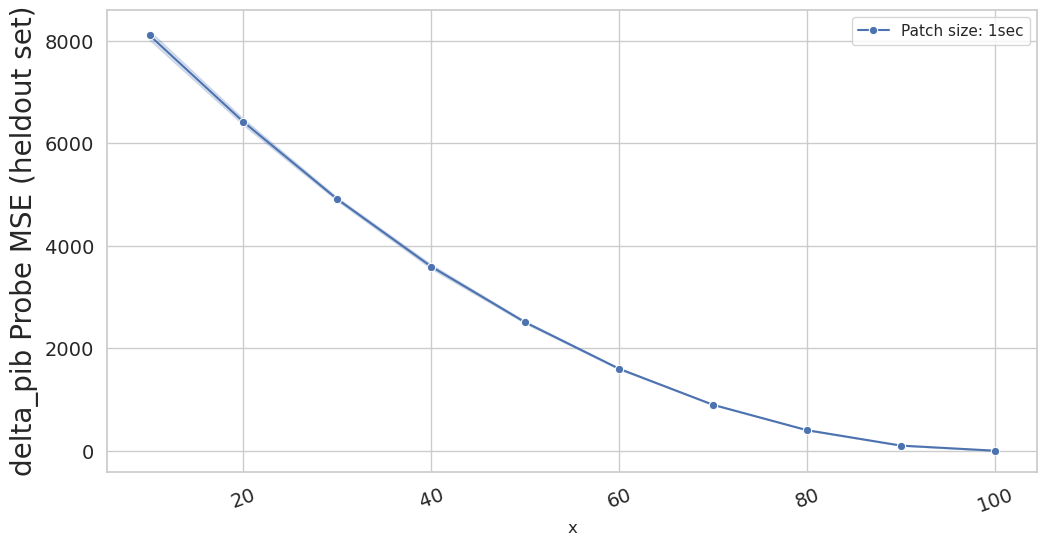

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("whitegrid")

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots()

_df_rows = []
for key, item in all_probes.items():
    # # print(key, item.keys())
    all_mse = item["model_metrics_across_folds"]["sequence_level"]["mean_squared_errors"]
    all_mae = item["model_metrics_across_folds"]["sequence_level"]["mean_absolute_errors"]
    all_r2 = item["model_metrics_across_folds"]["sequence_level"]["r2_scores"]
    for (mse, mae, r2) in zip(all_mse, all_mae, all_r2):
        tmp = {}
        tmp['x'] = key
        tmp['mse'] = mse
        tmp['mae'] = mae
        tmp['r2'] = r2
        _df_rows.append(tmp)
        
plot_df = pd.DataFrame(_df_rows)

sns.lineplot(
    data=plot_df, x='x', y='mse', errorbar='sd', err_style="band",
    # data=plot_df, x='x', y='mae', errorbar='sd', err_style="band",
    marker="o", 
    label=f"Patch size: {model_patch_size}",
    ax=ax,
)

plt.xticks(rotation=20)
plt.ylabel(f"{feature_type} Probe MSE (heldout set)", fontsize=20)
plt.show()

In [10]:
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Wall-clock time: {elapsed_time:.4f} seconds")

Wall-clock time: 141.9448 seconds
